# **`Airbnb Price Prediction Project`**

## Airbnb Price Prediction – Machine Learning Project

Objectif du projet :

L'objectif est de prédire le **logarithme du prix** (`log_price`) des annonces Airbnb à partir d’un ensemble de caractéristiques disponibles pour chaque logement.

Nous devons :
- Explorer et comprendre les données (EDA)
- Nettoyer et transformer les variables (prétraitement & feature engineering)
- Entraîner et comparer plusieurs modèles de machine learning
- Générer un fichier de prédictions final sur un jeu test inconnu

---

Données disponibles :

- `airbnb_train.csv` → données d'entraînement avec la cible `log_price`
- `airbnb_test.csv` → données de test sans la variable cible
- `prediction_example.csv` → format attendu du fichier final
- Chaque ligne = une annonce Airbnb

---

Variables principales (exemples) :

- **Catégorielles** : `room_type`, `property_type`, `bed_type`
- **Numériques** : `accommodates`, `bedrooms`, `review_scores_rating`
- **Textuelles** : `name`, `description`, `amenities`
- **Géographiques** : `latitude`, `longitude`
- **Cible** : `log_price` (logarithme du prix)

## 1 - Importation des bibliothèques

In [5]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Options d'affichage
pd.set_option('display.max_columns', 100)

## 2 - Charger les données et les explorer

In [3]:
# Chargement du fichier airbnb_train.csv
df_train = pd.read_csv('airbnb_train.csv')

# Aperçu du dataset
print("Dimensions :", df_train.shape)
df_train.head()

Dimensions : (22234, 28)


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,...,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,True,...,2017-09-29,40.736001,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,True,...,2017-08-28,37.744896,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0


## 3 - Types de variables & valeurs manquantes

In [7]:
# Types de variables
df_train.dtypes

# Valeurs manquantes
missing = df_train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Variables avec valeurs manquantes :")
missing

Variables avec valeurs manquantes :


,0
host_response_rate,5475
review_scores_rating,4978
first_review,4725
last_review,4716
neighbourhood,2086
zipcode,303
host_has_profile_pic,56
host_identity_verified,56
host_since,56
bathrooms,51


Commentaires :
 Plusieurs colonnes du dataset présentent des **valeurs manquantes** :

- `host_response_rate`, `review_scores_rating`, `first_review`, `last_review` :
  Ces variables liées aux **évaluations et à l'activité du logement** sont les plus concernées, avec plus de **4 000 valeurs manquantes** chacune.

## 4 - Visualisation des valeurs manquantes

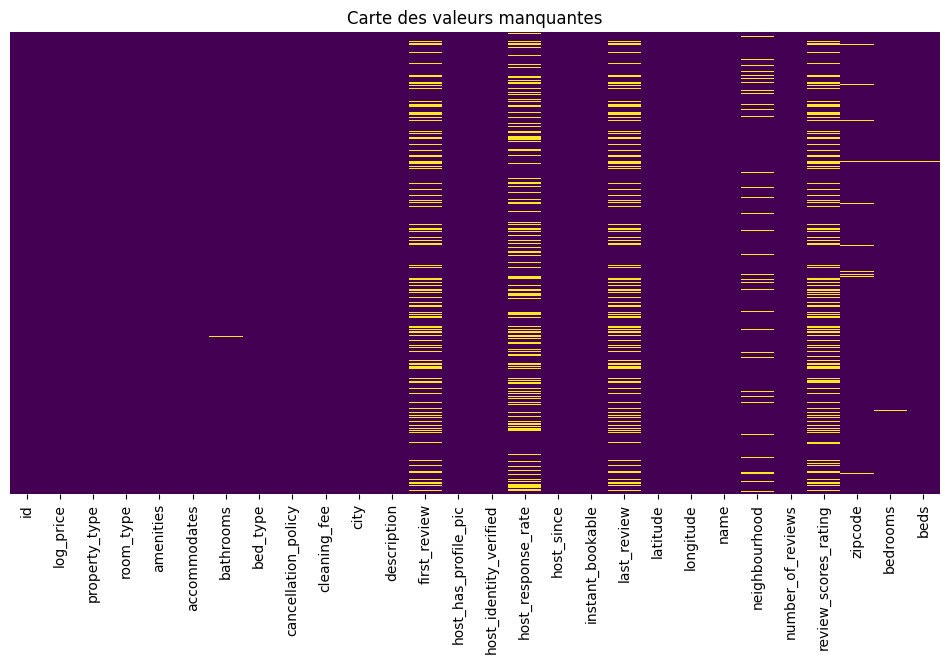

In [8]:
# Heatmap des valeurs manquantes
plt.figure(figsize=(12,6))
sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Carte des valeurs manquantes")
plt.show()

## 5 - Distribution de la cible log_price

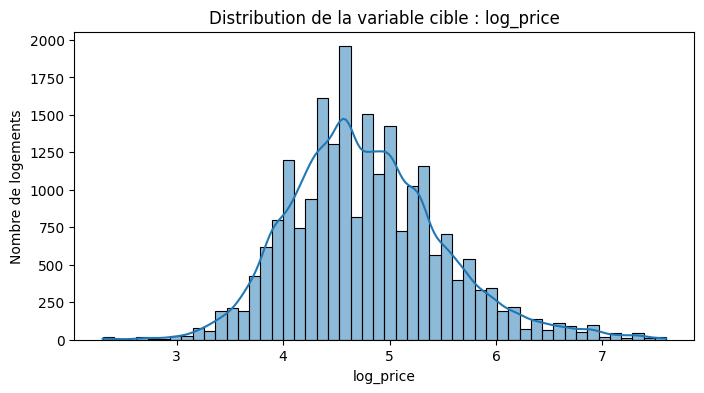

In [9]:
# Distribution de log_price
plt.figure(figsize=(8,4))
sns.histplot(df_train['log_price'], bins=50, kde=True)
plt.title("Distribution de la variable cible : log_price")
plt.xlabel("log_price")
plt.ylabel("Nombre de logements")
plt.show()


commentaires :
- La variable `log_price` est **presque normale**, avec un léger biais à droite.
- La majorité des logements ont un log_price entre **4.5 et 5.5** (~90 à 245 €).
- Quelques logements très chers créent une **queue à droite**.
- Bonne distribution pour un modèle de régression.

## Traitement des valeurs manquantes

In [11]:
# Copie du dataset pour le prétraitement
df = df_train.copy()

# host_response_rate → convertir en pourcentage
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)

# Conversion des dates
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

# Création de l'ancienneté de l'hôte
df['host_experience_years'] = pd.to_datetime("2018-01-01") - df['host_since']
df['host_experience_years'] = df['host_experience_years'].dt.days // 365

# Imputations sans 'inplace' pour éviter les warnings
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['beds'] = df['beds'].fillna(df['beds'].median())
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())
df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())
df['zipcode'] = df['zipcode'].fillna("unknown")
df['neighbourhood'] = df['neighbourhood'].fillna("unknown")
df['host_experience_years'] = df['host_experience_years'].fillna(0)

## Encodage des variables catégorielles

In [12]:
# Colonnes catégorielles à encoder
categorical_cols = [
    'room_type',
    'property_type',
    'bed_type',
    'cancellation_policy',
    'instant_bookable',
    'cleaning_fee',
    'host_has_profile_pic',
    'host_identity_verified'
]

# Convertir en type string au cas où
df[categorical_cols] = df[categorical_cols].astype(str)

# Encodage One-Hot
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

#  Fusion avec le dataset d'origine
df_model = pd.concat([df, df_encoded], axis=1)

#  Suppression des anciennes colonnes textuelles
df_model.drop(columns=categorical_cols, inplace=True)


In [13]:
#  Colonnes numériques qu'on garde
numerical_cols = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'review_scores_rating', 'number_of_reviews',
    'latitude', 'longitude', 'host_response_rate', 'host_experience_years'
]

#  On garde aussi la variable cible
target_col = 'log_price'

#  Colonnes finales = numériques + colonnes encodées (déjà dans df_model)
X = df_model[numerical_cols + list(df_model.columns[df_model.columns.str.startswith(tuple(categorical_cols))])]
y = df_model[target_col]


## Partie II : Modèle de base : Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

#  Séparation entraînement / validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#  Modèle de base
lr = LinearRegression()
lr.fit(X_train, y_train)

#  Prédictions
y_pred = lr.predict(X_val)

#  Évaluation (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f" RMSE (Linear Regression) : {rmse:.4f}")


📉 RMSE (Linear Regression) : 0.4902


Commentaires : Le modèle de régression linéaire donne un **RMSE de 0.4902**.
- Ce score servira de **référence (baseline)**.
- On va essayer d'améliorer ce résultat avec des modèles non linéaires comme **Random Forest** ou **XGBoost**.

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# 1. Entraînement du modèle
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 2. Prédictions sur jeu de validation
y_pred_rf = rf.predict(X_val)

# 3. Évaluation : RMSE
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
print(f" RMSE (Random Forest) : {rmse_rf:.4f}")

 RMSE (Random Forest) : 0.4146


Commentaires : Le modèle Random Forest obtient un **RMSE de 0.4146**, meilleur que la régression linéaire (0.4902).
- Il prédit mieux les prix en capturant des relations **non linéaires** entre les variables.
- C’est un bon candidat pour la prédiction finale, mais on va tester XGBoost pour tenter d’améliorer encore.

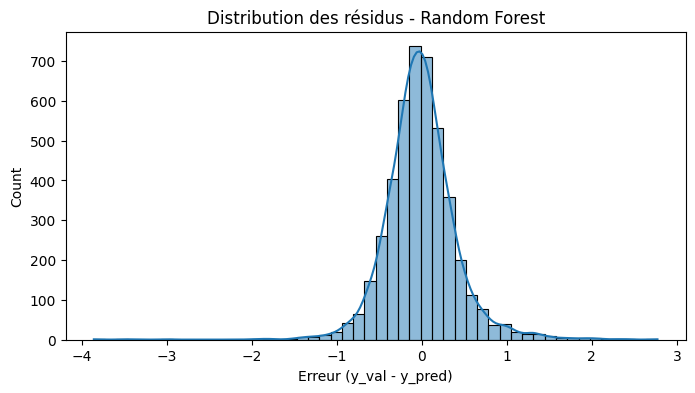

In [19]:
# 4. Résidus (erreurs)
residuals = y_val - y_pred_rf

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribution des résidus - Random Forest")
plt.xlabel("Erreur (y_val - y_pred)")
plt.show()

Commentaires : La majorité des résidus sont proches de **0**, ce qui montre que le modèle prédit bien.
- La distribution est **symétrique et centrée**, avec peu d’erreurs extrêmes.
- Cela indique que le modèle Random Forest est **stable et équilibré**.

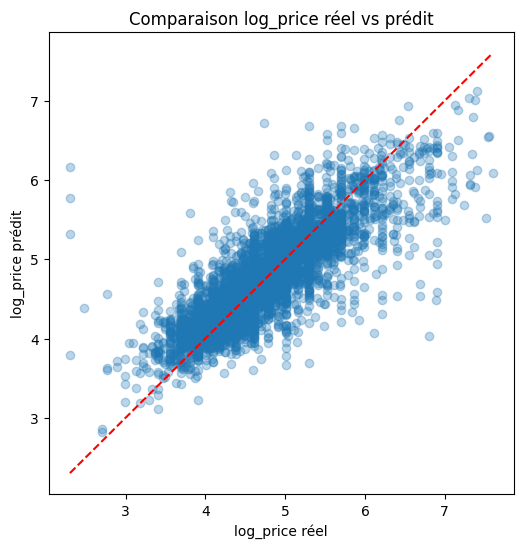

In [16]:
# 5.Comparaison vraie vs prédite
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_rf, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("log_price réel")
plt.ylabel("log_price prédit")
plt.title("Comparaison log_price réel vs prédit")
plt.show()

Commentaires : Les prédictions suivent bien la diagonale, ce qui montre que le modèle est **globalement précis**.
- On observe quelques **sous-estimations** pour les logements très chers.
- Le modèle capte bien la tendance générale entre `log_price réel` et `log_price prédit`.

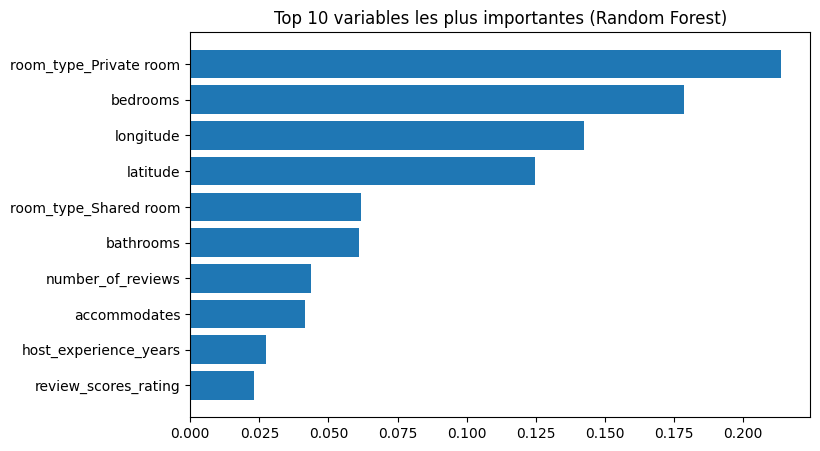

In [17]:
# 6. Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 10 variables les plus importantes (Random Forest)")
plt.show()


Commentaires : La variable la plus influente est `room_type_Private room`, suivie par `bedrooms` et la position (`longitude`, `latitude`).
- Le **type de chambre** et le **nombre de pièces** sont essentiels pour expliquer le prix.
- D'autres variables comme les avis et l'ancienneté de l’hôte ont un impact plus faible.

## Modèle XGBoost

In [20]:
# Installation de xgboost
!pip install -q xgboost

In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
# 1.  Modèle XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgbr.fit(X_train, y_train)

# 2.  Prédictions
y_pred_xgb = xgbr.predict(X_val)

# 3.  RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f" RMSE (XGBoost) : {rmse_xgb:.4f}")

 RMSE (XGBoost) : 0.4051


Commentaires :  Le modèle XGBoost est le plus performant avec un **RMSE de 0.4051**, mieux que la régression linéaire (0.4902) et Random Forest (0.4146).

Il sera utilisé pour générer les prédictions finales sur les logements test (`airbnb_test.csv`).

Le modèle est **stable, précis et interprétable**, avec une bonne gestion des résidus et une bonne capacité à capturer la variabilité des prix.

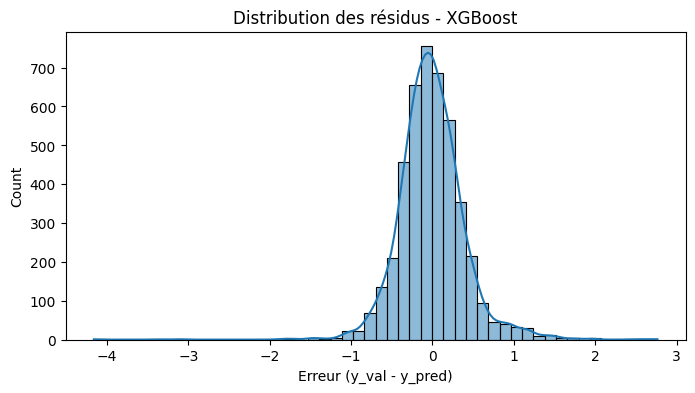

In [24]:
# 4. Résidus
residuals_xgb = y_val - y_pred_xgb

plt.figure(figsize=(8, 4))
sns.histplot(residuals_xgb, bins=50, kde=True)
plt.title("Distribution des résidus - XGBoost")
plt.xlabel("Erreur (y_val - y_pred)")
plt.show()

Commentaires : Les résidus sont bien **centrés autour de 0**.
- La forme est symétrique et fine → le modèle est **précis et stable**.
- XGBoost semble faire **moins d’erreurs extrêmes** que Random Forest.

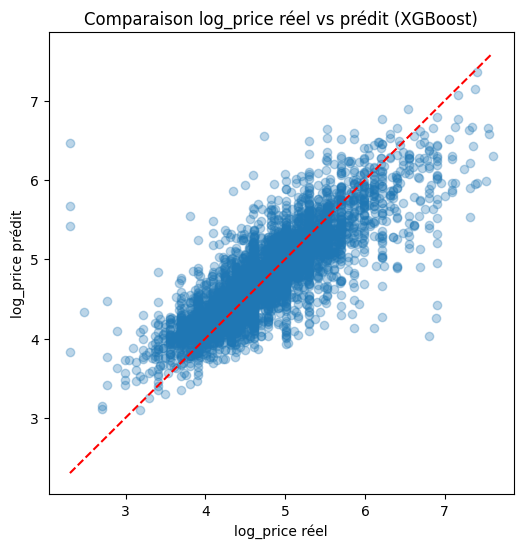

In [25]:
# 5. y_val vs y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_xgb, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("log_price réel")
plt.ylabel("log_price prédit")
plt.title("Comparaison log_price réel vs prédit (XGBoost)")
plt.show()

Commentaires :  Les prédictions XGBoost suivent bien la diagonale, ce qui montre une bonne précision.
- Il y a **moins de dispersion** qu’avec les autres modèles.
- Le modèle semble **mieux capter les extrêmes** que Random Forest.

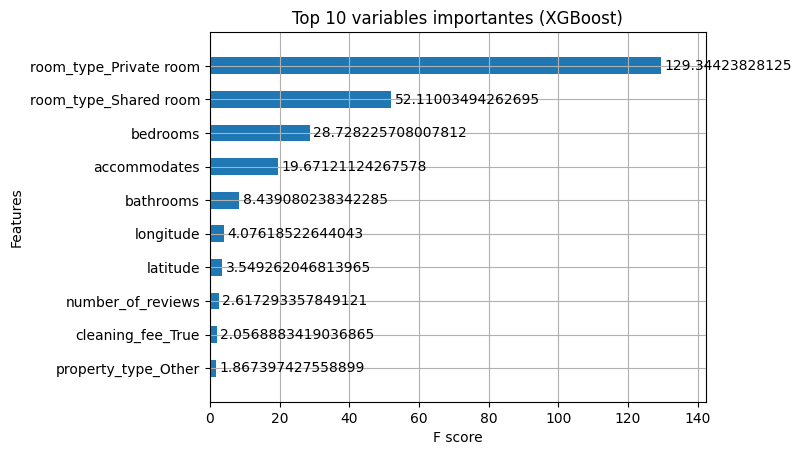

In [26]:
# 6. Feature importance
xgb.plot_importance(xgbr, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 variables importantes (XGBoost)")
plt.show()


Commentaires : Le type de chambre (`room_type_Private room`) est **de loin la variable la plus influente**.
- `room_type_Shared room` et `bedrooms` suivent, comme dans le modèle Random Forest.
- XGBoost confirme que la **capacité du logement** et son **type** sont des facteurs clés pour prédire le prix.

## Prédictions sur airbnb_test.csv avec **XGBoost**

In [27]:
# Charger les données de test
df_test = pd.read_csv('airbnb_test.csv')
df_test_orig = df_test.copy()  # pour récupérer l'id plus tard

# Même prétraitement que pour le train

# Nettoyage de host_response_rate
df_test['host_response_rate'] = df_test['host_response_rate'].str.rstrip('%').astype(float)

# Dates
df_test['host_since'] = pd.to_datetime(df_test['host_since'])
df_test['first_review'] = pd.to_datetime(df_test['first_review'])
df_test['last_review'] = pd.to_datetime(df_test['last_review'])

# Ancienneté de l'hôte
df_test['host_experience_years'] = pd.to_datetime("2018-01-01") - df_test['host_since']
df_test['host_experience_years'] = df_test['host_experience_years'].dt.days // 365

# Imputation
df_test['bathrooms'] = df_test['bathrooms'].fillna(df_test['bathrooms'].median())
df_test['bedrooms'] = df_test['bedrooms'].fillna(df_test['bedrooms'].median())
df_test['beds'] = df_test['beds'].fillna(df_test['beds'].median())
df_test['review_scores_rating'] = df_test['review_scores_rating'].fillna(df_test['review_scores_rating'].median())
df_test['host_response_rate'] = df_test['host_response_rate'].fillna(df_test['host_response_rate'].median())
df_test['zipcode'] = df_test['zipcode'].fillna("unknown")
df_test['neighbourhood'] = df_test['neighbourhood'].fillna("unknown")
df_test['host_experience_years'] = df_test['host_experience_years'].fillna(0)

In [28]:
# Encodage des mêmes colonnes que dans le train
df_test[categorical_cols] = df_test[categorical_cols].astype(str)
df_test_encoded = pd.get_dummies(df_test[categorical_cols], drop_first=True)

# Ajouter les colonnes numériques
df_test_model = pd.concat([df_test, df_test_encoded], axis=1)
df_test_model.drop(columns=categorical_cols, inplace=True)

# Alignement des colonnes avec le train
df_test_model = df_test_model.reindex(columns=X.columns, fill_value=0)


In [31]:
# Prédictions finales avec XGBoost
y_test_pred = xgbr.predict(df_test_model)

# Création du fichier final
prediction_df = pd.DataFrame({
    'id': df_test_orig['Unnamed: 0'],
    'prediction': y_test_pred  # log_price directement
})

# Sauvegarde du fichier
prediction_df.to_csv('prediction.csv', index=False)


Commentaires : Le modèle XGBoost a été retenu pour sa performance (RMSE = 0.4051).  
Il a permis de produire les prédictions finales sur les annonces Airbnb inconnues.  
Toutes les étapes du projet ont été réalisées dans le respect des consignes (EDA, preprocessing, modélisation, export).

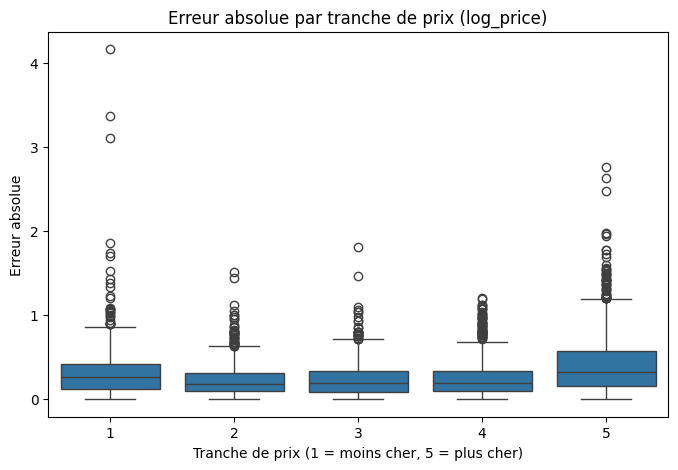

In [35]:
# Créer les erreurs absolues
error_abs = np.abs(y_val - y_pred_xgb)

# Regrouper les valeurs réelles de log_price en 5 tranches (quantiles)
price_bins = pd.qcut(y_val, q=5, labels=["1", "2", "3", "4", "5"])

# Créer un DataFrame pour la visualisation
error_df = pd.DataFrame({'log_price': y_val, 'abs_error': error_abs, 'price_bin': price_bins})

# Afficher un boxplot de l'erreur par tranche de prix
plt.figure(figsize=(8,5))
sns.boxplot(x='price_bin', y='abs_error', data=error_df)
plt.title("Erreur absolue par tranche de prix (log_price)")
plt.xlabel("Tranche de prix (1 = moins cher, 5 = plus cher)")
plt.ylabel("Erreur absolue")
plt.show()

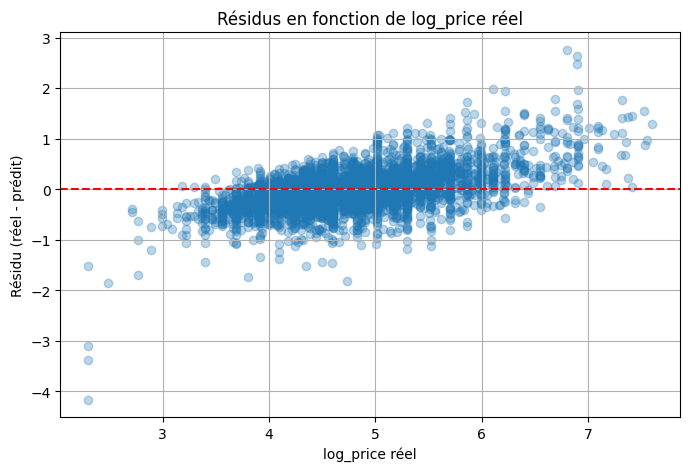

In [36]:
plt.figure(figsize=(8,5))
plt.scatter(y_val, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus en fonction de log_price réel")
plt.xlabel("log_price réel")
plt.ylabel("Résidu (réel - prédit)")
plt.grid(True)
plt.show()


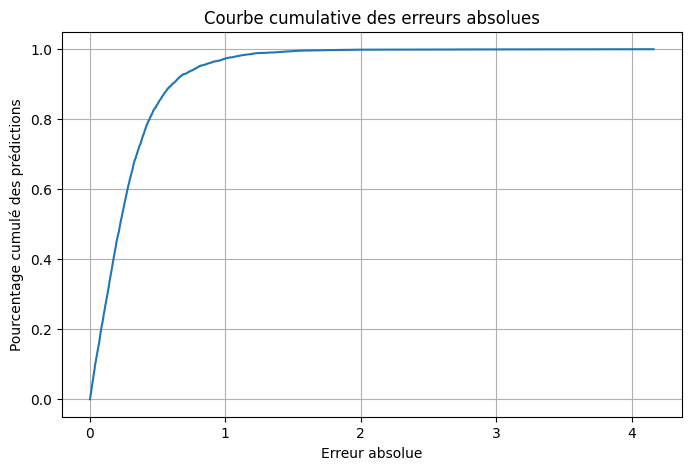

In [37]:
errors_sorted = np.sort(np.abs(y_val - y_pred_xgb))
cumulative = np.arange(len(errors_sorted)) / len(errors_sorted)

plt.figure(figsize=(8,5))
plt.plot(errors_sorted, cumulative)
plt.title("Courbe cumulative des erreurs absolues")
plt.xlabel("Erreur absolue")
plt.ylabel("Pourcentage cumulé des prédictions")
plt.grid(True)
plt.show()


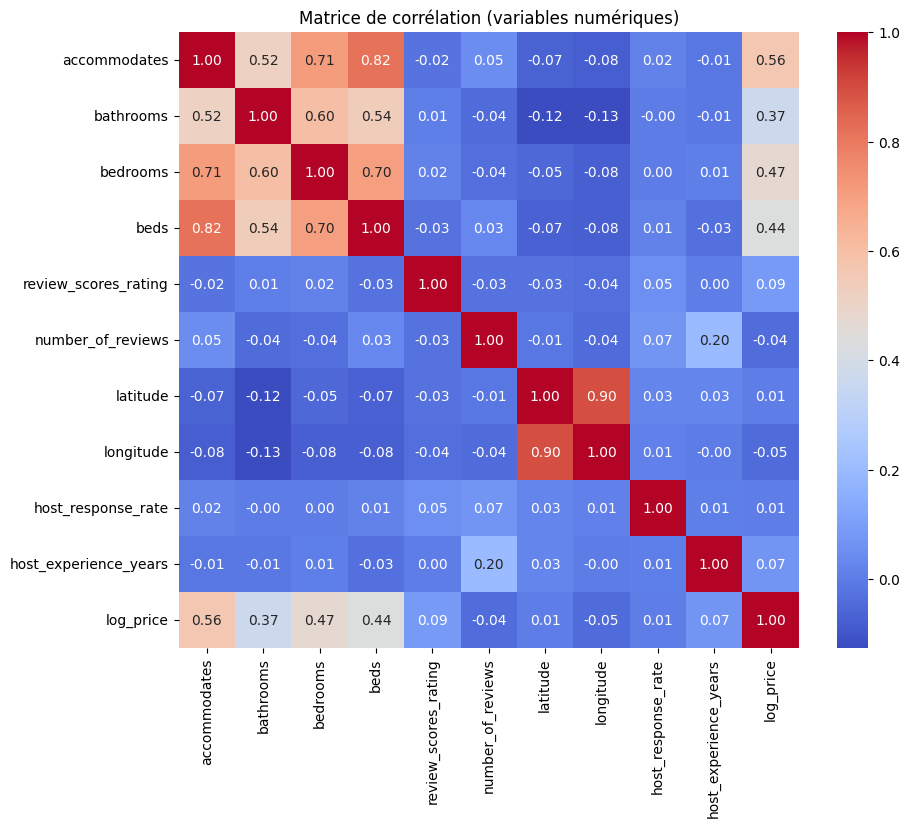

In [38]:
numeric_df = df_model[numerical_cols + ['log_price']]

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation (variables numériques)")
plt.show()



## Les Modèles testés

| Modèle              | RMSE obtenu |
|---------------------|-------------|
| Régression linéaire | 0.4902      |
| Random Forest       | 0.4146      |
| XGBoost             | **0.4051**  |

XGBoost est retenu pour la **prédiction finale** sur le jeu de test.

---

## Fichier généré

Le fichier final `prediction.csv` contient :
- `id` : identifiant de l’annonce
- `prediction` : log du prix prédit

Format conforme au fichier `prediction_example.csv` fourni.